<a href="https://colab.research.google.com/github/timmmariya/Empirical-Law-Studies/blob/main/5_%D0%9F%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Представленный Colab Notebook является частью серии наработок по исследованиям в области практической оценки судопроизводства методами численного анализа, проводимых [НУЛ анализа данных правоприменения НИУ ВШЭ](https://adp.hse.ru/). 

Контактная информация рабочей группы: gkrasnozhenov@hse.ru (Григорий Григорьевич Красноженов, ЗавЛаб НУЛ АДП), timmariya541@gmail.com (Мария Тимонина, стажер, ответственный за текущую задачу)

Материалом для анализа служат **данные системы арбитражных судов РФ**.

---


***Hoping that Next paragraph will come true soon...***

На более ранних этапах исследования осуществлена первичная очистка данных. Далее с целью оптимизации обработки блоков базы, относящихся к отдельным временным рядам, строки отсортированы согласно введенной классификации по списку значимых признаков. Подробнее: [предыдущий Colab Notebook](https://colab.research.google.com/drive/123fHdRPJFeiOs8FFUWg7PaFdr99uUVHu?usp=sharing)


#### Реализуем стандартный пролог - подключим необходимые библиотеки и загрузим данные из SQL-базы в pandas dataFrame

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot') # стиль графиков
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/APwithEndDates.csv"
df = pd.read_csv(path, sep=',')

# **Постановка задачи**

Чтобы проводить сравнительный анализ статистики судебных разбирательств, требуется выделить **временные ряды**.  Они должны отвечать следующим требованиям:

1) объединять споры одной или близких направлений, чтобы характеристики ряда могли лечь в основу описания некоторого раздела практики арбитражного суда (существуют различные критерии, предстоит выбрать наиболее релевантные для нашего исследования);

2) содержать достаточное количество дел, чтобы послужить выборкой для моделирования распределения случайной величины (установим минимальный порог в 1000 дел для начала);

**В этой тетрадке** вы можете найти код и краткое описание процесса построения рядов на основании информации из исходной базы.

---


In [ ]:
df.head()

,Номер,Суд,Вид Спора,Категория Спора,Сумма Иска,Сумма Взысканий,Начало,Продолжительность,Конец
0,34925-13/1941,АС Воронежской области,А,О взыскании обязательных платежей и санкций по...,0.0,0.0,2014-01-31,48,2014-03-20
1,А01-120/2014,АС Республики Адыгея,Г,О признании права собственности,0.0,0.0,2014-01-31,8,2014-02-08
2,А01-121/2014,АС Республики Адыгея,Г,О неисполнении или ненадлежащем исполнении обя...,34484.9,36484.9,2014-01-31,670,2015-12-02
3,А01-122/2014,АС СКО,Г,Иные экономические споры,132000.0,176979.0,2014-01-31,419,2015-03-26
4,А01-123/2014,АС Республики Адыгея,А,О привлечении к административной ответственности,0.0,0.0,2014-01-31,42,2014-03-14


#Функция для упаковки записей из базы во временной ряд на Python 

Обернем вычисления в удобную функцию, принимающую на вход dataFrame вида, проиллюстрированного выше и переменную-маркер.

Если передается маркер 1 (или любое другое число, не равное 0), то будет построена визуализация данных - **график** в осях (Временные интервалы, Значения измеряемой характеристики). Если же график не требуется, следует передать 0.

По завершении работы функция  `TS_visualization_basic_info(dataframe_in, dataframe_out)` будет выводить:

* общее количество дел в базе

* Среднее значение продолжительности споров в базе

* самую раннюю и самую позднюю из дат начала рассмотрения дел, собранных в `dataframe_in`

и возвращать временной ряд значений наблюдаемой характеристики с индексами-датами типа Timestamp (в настоящий момент это ***Средняя за месяц продолжительность споров***).

In [ ]:
def TS_visualization_basic_info(d1, need_plt):
    #вывод на печать граничных интервалов
    print('Количество дел в категории:', d1.shape[0])
    print('Средняя прод-ть споров категории за все время:', d1['Продолжительность'].mean())
    print('First start:', d1['Начало'].min(), '\nLast start:', d1['Начало'].max())

    #создание массива, где в качестве индекса-месяца будет первый день каждого месяца
    date_from = pd.Timestamp(d1['Начало'].min()) + pd.DateOffset(months=-1)
    date_to = pd.Timestamp(d1['Начало'].max())
    index_left = pd.date_range(date_from, date_to, freq="M") + pd.DateOffset(days=1)
    index_right = index_left + pd.DateOffset(months=1, days=-1)                     

    td1 = pd.DataFrame(pd.Series(0, index=index_left), columns=['MeanLength'])

    month_start = index_left.astype(str)
    month_end = index_right.astype(str)
    #вычисление наблюдаемой характеристики для каждого месяца
    for mon in range(len(td1)):
      td1.MeanLength[mon] = d1[(d1['Начало'] <= month_end[mon]) & (d1['Конец'] >= month_start[mon])]['Продолжительность'].mean()

    #рисование визуализации ряда - графика в двух осях
    if (need_plt) :
      td1.plot(figsize=(8, 6), ylim=(0, 3 * d1['Продолжительность'].mean()))
    return td1


# Основная часть: Упаковка БД КАД в формат временных рядов

## Черновое тестирование
Была составлена небольшая подборка репрезентативных и достаточно объемных групп дел по категориям, чтобы обкатывать алгоритмы, пока полная классификация находится на доработке.


Построим графики ряда для каждой из них.

1. Аренда транспортных средств (параграф 3 главы 34 Гражданского кодекса): Excel зеленые строки 26-30 : 2831 дело;

In [ ]:
d1 = df[(df['Категория Спора'] == 'Аренда транспортных средств - Заключение договора') |
        (df['Категория Спора'] == 'Аренда транспортных средств - Недействительность договора') |
        (df['Категория Спора'] == 'Аренда транспортных средств - Неисполнение или ненадлежащее исполнение обязательств')]

ts1 = TS_visualization_basic_info(d1, 0)

Количество дел в категории: 2831
Средняя прод-ть споров категории за все время: 111.27799364182268
First start: 2014-01-09 
Last start: 2016-06-01


2. Финансовая аренда (лизинг) (параграф 6 главы 34 ГК) : оранж, Excel строки 189, 190, 360-364 : 26689 дел;

In [ ]:
d2 = df[(df['Категория Спора'] == 'Лизинг - Заключение договора') |
        (df['Категория Спора'] == 'Лизинг - Недействительность договора') |
        (df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам финансовой аренды (лизинга)')]

ts2 = TS_visualization_basic_info(d2, 0)

Количество дел в категории: 26689
Средняя прод-ть споров категории за все время: 128.3581625388737
First start: 2014-01-09 
Last start: 2016-06-01


3. Договоры купли-продажи недвижимости и предприятий (параграфы 7 и 8 главы 30 ГК) : синие Excel строки 181-188, 331-332 - суммарно 4326 дел;

In [ ]:
d3 = df[(df['Категория Спора'] == 'Купля-продажа недвижимости - Заключение договора') |
        (df['Категория Спора'] == 'Купля-продажа недвижимости - Недействительность договора') |
        (df['Категория Спора'] == 'Купля-продажа недвижимости - Неисполнение или ненадлежащее исполнение обязательств') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Заключение договора') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Недействительность договора') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Неисполнение или ненадлежащее исполнение обязательств') |
        (df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам купли-продажи недвижимости и предприятий')]

ts3 = TS_visualization_basic_info(d3, 0)

Количество дел в категории: 4326
Средняя прод-ть споров категории за все время: 155.12043458159962
First start: 2014-01-09 
Last start: 2016-06-01


4. Признание права собственности (глава 14 ГК) : желтые Excel стр 423-430, 672-674 - суммарно 29526 дел;

In [ ]:
d4 = df[(df['Категория Спора'] == 'О признании права собственности') |
        (df['Категория Спора'] == 'О признании права собственности на землю') |
        (df['Категория Спора'] == 'Споры, связанные с защитой права собственности')]

ts4 = TS_visualization_basic_info(d4, 0)

Количество дел в категории: 29526
Средняя прод-ть споров категории за все время: 139.56211474632528
First start: 2014-01-05 
Last start: 2016-06-01


5. Авторское право (глава 70 ГК) - Excel строки 271-274, 649-652, 772, 778 - суммарно 10933 дела

In [ ]:
d5 = df[(df['Категория Спора'] == 'О защите авторских и смежных прав') |
        (df['Категория Спора'] == 'Связанные с защитой объектов авторского права') |
        (df['Категория Спора'] == 'о предоставлении или прекращении правовой охраны рез-ов интеллект. деятельности и средств индивидуализации (за искл. объек-ов автор-их и смеж. прав, топологий интегр. микросхем)') |
        (df['Категория Спора'] == 'о защите авторских прав')]

ts5 = TS_visualization_basic_info(d5, 0)

Количество дел в категории: 10933
Средняя прод-ть споров категории за все время: 125.72688191713162
First start: 2014-01-09 
Last start: 2016-06-01


Оценим схожесть графиков визуально с помощью изображения на общей плоскости.

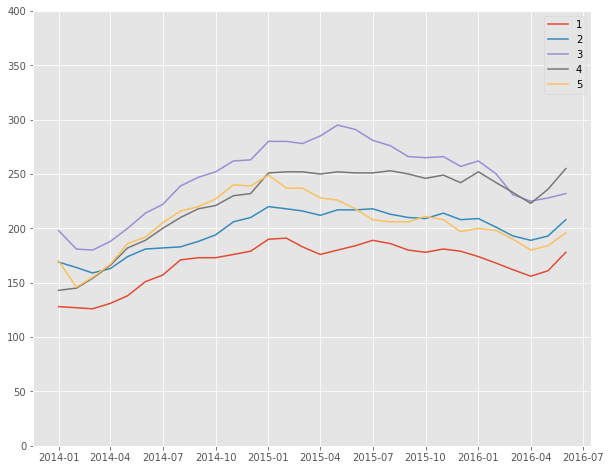

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)
plt.plot(ts4)
plt.plot(ts5)

plt.ylim(0, 400)
plt.legend(['1', '2', '3', '4', '5'])
plt.show()

На первый взгляд заметны общие тенденции в поведении на определенных участках. Можно предположить, что ряды сильно коррелированны между собой. Сформулированные предположения будут проверены в следующих частях  вычислительных экспертиментов.

Выгрузка рядов из тетрадки:

In [ ]:
ts1.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/TimeSeries1.csv', sep=',')

ts2.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/TimeSeries2.csv', sep=',')
ts3.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/TimeSeries3.csv', sep=',')
ts4.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/TimeSeries4.csv', sep=',')
ts5.to_csv('/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/TimeSeries5.csv', sep=',')

# Резюмирующая заметка